## **GPU**

In [1]:
!nvidia-smi

Fri Aug  2 05:17:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Install**

In [2]:
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# **Imports 📢**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset 🗂️**

## Transform

In [76]:
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                std=(0.2023, 0.1994, 0.2010))
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                std=(0.2023, 0.1994, 0.2010))
])

## CIFAR Dataset

In [77]:
train_set = CIFAR10(root='./cifar10', train=True,
                    download=True, transform=transform_train)

test_set = CIFAR10(root='./cifar10', train=False,
                   download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [78]:
torch.FloatTensor(train_set.data/255.).mean(dim=[0, 1, 2]), torch.FloatTensor(train_set.data/255.).std(dim=[0, 1, 2])

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [79]:
train_set

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [80]:
train_set[15]

(tensor([[[-2.4291, -0.3936, -0.4324,  ..., -0.1998, -0.2386, -0.3161],
          [-2.4291, -0.3161, -0.3355,  ...,  0.1685,  0.0134,  0.0910],
          [-2.4291, -0.2580, -0.2773,  ...,  0.6338,  0.5950,  0.8276],
          ...,
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],
 
         [[-2.4183,  1.0234,  0.9841,  ...,  0.9251,  1.0038,  1.0234],
          [-2.4183,  1.1021,  1.0824,  ...,  0.6694,  0.7678,  1.0431],
          [-2.4183,  1.1808,  1.1414,  ...,  0.9054,  0.8858,  1.1021],
          ...,
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],
 
         [[-2.2214,  2.3830,  2.3440,  ...,  2.0123,  2.2074,  2.3440],
          [-2.2214,  2.4806,

In [81]:
train_set[15][0].shape

torch.Size([3, 32, 32])

In [82]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [83]:
train_set.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [84]:
len(train_set)

50000

## DataLoader

In [85]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [86]:
x, y = next(iter(train_loader))
print(x.shape)
print(y)

torch.Size([64, 3, 32, 32])
tensor([9, 5, 2, 2, 2, 8, 4, 5, 9, 7, 5, 8, 5, 9, 8, 4, 2, 9, 6, 6, 8, 4, 1, 8,
        3, 4, 5, 8, 3, 3, 2, 2, 5, 2, 5, 0, 7, 3, 3, 5, 8, 3, 0, 8, 6, 0, 1, 0,
        7, 1, 4, 9, 4, 3, 8, 4, 9, 0, 0, 0, 8, 2, 5, 3])


## Visualize

In [87]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

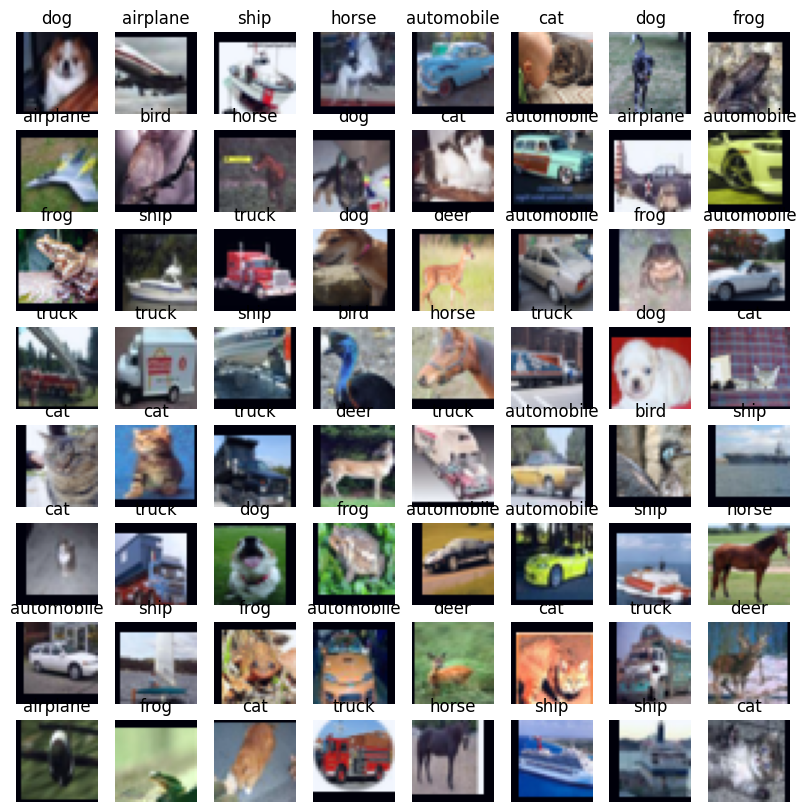

In [88]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# **Model 🧠**

In [89]:
def CNN():
  network = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.Conv2d(64, 64, 3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.MaxPool2d(2, 2), # BSx64x16x16

      nn.Conv2d(64, 128, 3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),

      nn.Conv2d(128, 128, 3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),

      nn.MaxPool2d(2,2), # 8x8

      nn.Conv2d(128, 256, 3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),

      nn.Conv2d(256, 256, 3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      # BSx256x8x8 -> BSx256x1x1
      nn.AdaptiveAvgPool2d(output_size=(1, 1)), # BS1x1

      nn.Flatten(), # BSx256
      nn.Linear(256, 10)
  )
  return network

In [90]:
# model(torch.randn(10, 3, 32, 32)).shape

In [91]:
def conv3x3_bn_af(in_channels, out_channels):
  module = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )
  return module

In [92]:
def CNN():
  network = nn.Sequential(
      conv3x3_bn_af(3, 64),
      conv3x3_bn_af(64, 64),
      nn.MaxPool2d(2, 2), # 16x16

      conv3x3_bn_af(64, 128),
      conv3x3_bn_af(128, 128),
      nn.MaxPool2d(2, 2), # 8x8

      conv3x3_bn_af(128, 256),
      conv3x3_bn_af(256, 256),
      nn.MaxPool2d(2, 2), # 4x4

      conv3x3_bn_af(256, 512),
      conv3x3_bn_af(512, 512),
      nn.AdaptiveAvgPool2d(output_size=(1, 1)), # 1x1

      nn.Flatten(),
      nn.Linear(512, 10) # classifier
  )
  return network

In [93]:
model = CNN()

In [94]:
model[0][0].weight.shape  # N x Cin x Wf x Hf

torch.Size([64, 3, 3, 3])

In [95]:
model[0][0].bias.shape

torch.Size([64])

In [96]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [97]:
num_params(model)

4.694346

# **Device ⚙️**

In [98]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

In [99]:
device

'cuda'

# **Loss & Optimizer ⚖️**

In [67]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# **Utils 🧰**

In [100]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [101]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=10).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [102]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=10).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Efficient way for set hyperparams 🔨**

## Step 1: check forward path

Calculate loss for one batch

In [71]:
x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(2.3357, device='cuda:0', grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [72]:
_, mini_train_dataset = random_split(train_set, (len(train_set) - 1000, 1000))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [73]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 50/50 [00:01<00:00, 39.87batch/s, accuracy=55.1, loss=1.23]


## Step 3: select best lr

Train all data for one epoch

In [74]:
num_epochs = 2
for lr in [0.1, 0.01]:
  print(f'LR={lr}')
  model = CNN().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.1


Epoch 1: 100%|██████████| 782/782 [00:41<00:00, 19.04batch/s, accuracy=72.7, loss=0.779]



LR=0.01


Epoch 1: 100%|██████████| 782/782 [00:42<00:00, 18.56batch/s, accuracy=65.1, loss=0.981]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [42]:
num_epochs = 5

for lr in [0.08, 0.09, 0.1, 0.15, 0.2]:
  for wd in [1e-4, 1e-5, 0.]:
    model = CNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

LR=0.08, WD=0.0001


Epoch 4: 100%|██████████| 782/782 [00:31<00:00, 24.82batch/s, accuracy=89.6, loss=0.296]



LR=0.08, WD=1e-05


Epoch 1:  48%|████▊     | 375/782 [00:15<00:16, 24.71batch/s, accuracy=76.1, loss=0.676]


KeyboardInterrupt: 

## Step 5: train more epochs

In [112]:
model = CNN().to(device)

In [113]:
lr = 0.05
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

In [115]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [116]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('model saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 782/782 [00:41<00:00, 18.70batch/s, accuracy=55.3, loss=1.24]


model saved!
Valid: Loss = 1.842, Acc = 0.4637



Epoch 1: 100%|██████████| 782/782 [00:41<00:00, 19.00batch/s, accuracy=72.5, loss=0.783]


model saved!
Valid: Loss = 1.48, Acc = 0.5612



Epoch 2: 100%|██████████| 782/782 [00:41<00:00, 18.94batch/s, accuracy=77.9, loss=0.636]


model saved!
Valid: Loss = 1.401, Acc = 0.5962



Epoch 3: 100%|██████████| 782/782 [00:41<00:00, 18.99batch/s, accuracy=80.7, loss=0.555]


Valid: Loss = 1.562, Acc = 0.5814



Epoch 4: 100%|██████████| 782/782 [00:40<00:00, 19.13batch/s, accuracy=82.9, loss=0.496]


model saved!
Valid: Loss = 0.8045, Acc = 0.728



Epoch 5: 100%|██████████| 782/782 [00:41<00:00, 18.80batch/s, accuracy=84.5, loss=0.446]


Valid: Loss = 0.8089, Acc = 0.7534



Epoch 6: 100%|██████████| 782/782 [00:41<00:00, 18.94batch/s, accuracy=86, loss=0.402]


model saved!
Valid: Loss = 0.5008, Acc = 0.8327



Epoch 7: 100%|██████████| 782/782 [00:41<00:00, 18.75batch/s, accuracy=86.7, loss=0.38]


Valid: Loss = 0.9075, Acc = 0.739



Epoch 8: 100%|██████████| 782/782 [00:41<00:00, 18.87batch/s, accuracy=87.8, loss=0.35]


Valid: Loss = 0.5686, Acc = 0.8198



Epoch 9: 100%|██████████| 782/782 [00:41<00:00, 18.80batch/s, accuracy=88.6, loss=0.326]


Valid: Loss = 0.5692, Acc = 0.8224



Epoch 10: 100%|██████████| 782/782 [00:42<00:00, 18.55batch/s, accuracy=89.5, loss=0.305]


Valid: Loss = 0.5983, Acc = 0.8194



Epoch 11: 100%|██████████| 782/782 [00:41<00:00, 18.83batch/s, accuracy=89.9, loss=0.287]


Valid: Loss = 0.5901, Acc = 0.8166



Epoch 12: 100%|██████████| 782/782 [00:41<00:00, 19.02batch/s, accuracy=90.3, loss=0.272]


model saved!
Valid: Loss = 0.4978, Acc = 0.8405



Epoch 13: 100%|██████████| 782/782 [00:41<00:00, 18.66batch/s, accuracy=91.1, loss=0.254]


Valid: Loss = 1.297, Acc = 0.6715



Epoch 14: 100%|██████████| 782/782 [00:41<00:00, 18.87batch/s, accuracy=91.5, loss=0.242]


model saved!
Valid: Loss = 0.4433, Acc = 0.8633



Epoch 15: 100%|██████████| 782/782 [00:41<00:00, 18.89batch/s, accuracy=92, loss=0.23]


Valid: Loss = 0.7857, Acc = 0.796



Epoch 16: 100%|██████████| 782/782 [00:41<00:00, 18.87batch/s, accuracy=92.5, loss=0.216]


Valid: Loss = 0.4581, Acc = 0.8604



Epoch 17: 100%|██████████| 782/782 [00:40<00:00, 19.11batch/s, accuracy=92.9, loss=0.204]


model saved!
Valid: Loss = 0.4162, Acc = 0.871



Epoch 18: 100%|██████████| 782/782 [00:44<00:00, 17.51batch/s, accuracy=93.1, loss=0.195]


Valid: Loss = 0.4717, Acc = 0.8524



Epoch 19: 100%|██████████| 782/782 [00:44<00:00, 17.46batch/s, accuracy=93.5, loss=0.184]


Valid: Loss = 0.5672, Acc = 0.834



# **Plot**

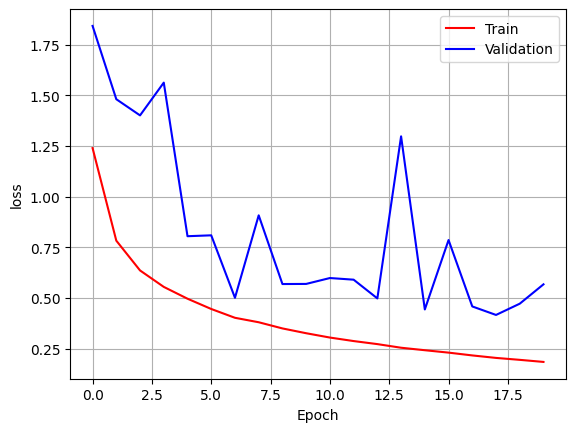

In [117]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

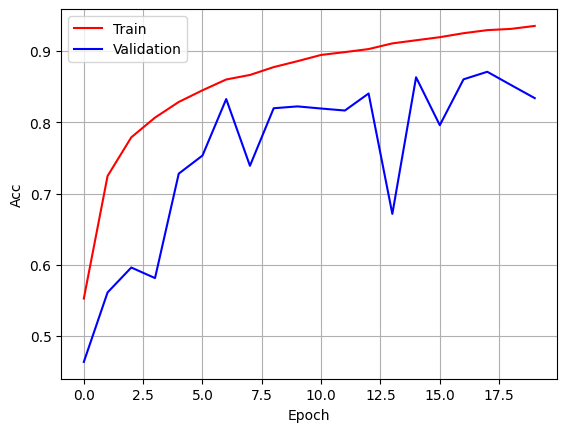

In [118]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()